<a href="https://colab.research.google.com/github/kartikeyaj0/AI-Codes/blob/master/ai_hw2_q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 2:

In this problem we will try to find optimal policy using policy and value iteration to traverse the following grid:

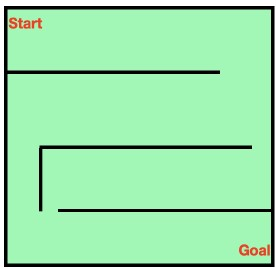


We start by importing the necessary libraries.

In [ ]:
import collections
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

As per the problem definition, we define the following variables:

In [ ]:
GRID_SIZE = 15
grid = [[0]*GRID_SIZE for _ in range(GRID_SIZE)]

START = (0, 0)
GOAL = (14, 14)

# Action Space
A = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1),
    'stay': (0, 0)
}

# State Space
S = [(x, y) for x in range(15) for y in range(15)]

# Noise
ALPHA = [0.2, 0.8]

We will define a utility function s_next_calc which computes the index of the next state given current state and action.

In [ ]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: New state coordinates in the grid
    '''
    return (s[0] + A[a][0], s[1] + A[a][1])

We will also use another utility function hit_wall, which checks if the action at current state leads to a collision with a wall.

In [ ]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    x, y = curr

    # Check for grid boundaries
    if x == 0 and action == 'up':
        return True
    if x == 14 and action == 'down':
        return True
    if y == 0 and action == 'left':
        return True
    if y == 14 and action == 'right':
        return True

    # The problem statement describes 4 walls in addition to grid boundaries

    # 1st horizontal wall after 3 - (0 to 11)
    # Going down from (3, (0,11)) is not allowed
    # Coming up from (4, (0,11)) is not allowed
    if x == 3 and 0 <= y <= 11 and action == 'down':
        return True
    elif x == 4 and 0 <= y <= 11 and action == 'up':
        return True

    # 2nd horizontal wall after 7 - (2, 13)
    # Going down from (7, (2,13)) is not allowed
    # Coming up from (8, (2,13)) is not allowed
    if x == 7 and 2 <= y <= 13 and action == 'down':
        return True
    elif x == 8 and 2 <= y <= 13 and action == 'up':
        return True

    # 3rd horizontal wall after 11
    # Going down from (11, (3,14)) is not allowed
    # Coming up from (12, (3,14)) is not allowed
    if x == 11 and 3 <= y <= 14 and action == 'down':
        return True
    elif x == 12 and 3 <= y <= 14 and action == 'up':
        return True

    # vertical wall 8 to 11
    # hit on moving from ((8,11), 1) to ((8,11), 2)
    # and viceversa
    if y == 1 and 8 <= x <= 11 and action == 'right':
        return True
    elif y == 2 and 8 <= x <= 11 and action == 'left':
        return True

    # If no walls hit, return False
    return False


Now we define the reward function as per the problem statement.

In [ ]:
def R(s, a):
    '''Reward function for the agent
    : param curr: Current state of the agent
    : param action: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return 0
    elif hit_wall(s, a):
        return -10000
    else:
        return -1

We will use the following function to calculate the transition probabilities to state s_next from current state s upon action a.

In [ ]:
def P(s_next, s, a, alpha):
    '''This function returns probabilities for each action at agent's
    current state.
    : param curr: Current state of the agent
    : param action: Action the agent takes at the current state
    : returns: Transition probability for the action at current state
    '''
    # GOAL is absorbing
    if s == GOAL:
        if s_next == s:
          return 1
        else:
            return 0

    # If wall hit, next state is current state
    if hit_wall(s, a):
        # Illegal action with s = s'
        if s_next == s:
            return 1
        # Illegal action with s != s'
        else:
            return 0

    # Legal action with adjacent s and s'
    if s_next == s_next_calc(s, a):
        return 1 - alpha
    else:
        # Agent moves to another adjacent state instead of s' due to noise in a
        # Generate all other neighbors of s by applying actions other than a
        other_s_next = [s_next_calc(s, i)
                    for i in A if i is not a]
        if s_next in other_s_next:
            return alpha/4
    return 0

## A* with Manhattan Distance hueristic

In [ ]:
def manhattan_distance(src, dst):
    return abs(src[0] - dst[0]) + abs(src[1] - dst[1])

We can modify the astar_path source code to also return the f(n) values for the explored nodes.

In [ ]:
"""Shortest paths and path lengths using the A* ("A star") algorithm.
"""
from heapq import heappush, heappop
from itertools import count

import networkx as nx
from networkx.algorithms.shortest_paths.weighted import _weight_function

__all__ = ["astar_path", "astar_path_length"]


def modified_astar_path(G, source, target, heuristic=None, weight="weight"):
    """Returns a list of nodes in a shortest path between source and target
    using the A* ("A-star") algorithm.

    There may be more than one shortest path.  This returns only one.

    Parameters
    ----------
    G : NetworkX graph

    source : node
       Starting node for path

    target : node
       Ending node for path

    heuristic : function
       A function to evaluate the estimate of the distance
       from the a node to the target.  The function takes
       two nodes arguments and must return a number.

    weight : string or function
       If this is a string, then edge weights will be accessed via the
       edge attribute with this key (that is, the weight of the edge
       joining `u` to `v` will be ``G.edges[u, v][weight]``). If no
       such edge attribute exists, the weight of the edge is assumed to
       be one.
       If this is a function, the weight of an edge is the value
       returned by the function. The function must accept exactly three
       positional arguments: the two endpoints of an edge and the
       dictionary of edge attributes for that edge. The function must
       return a number.

    Raises
    ------
    NetworkXNoPath
        If no path exists between source and target.

    Examples
    --------
    >>> G = nx.path_graph(5)
    >>> print(nx.astar_path(G, 0, 4))
    [0, 1, 2, 3, 4]
    >>> G = nx.grid_graph(dim=[3, 3])  # nodes are two-tuples (x,y)
    >>> nx.set_edge_attributes(G, {e: e[1][0] * 2 for e in G.edges()}, "cost")
    >>> def dist(a, b):
    ...     (x1, y1) = a
    ...     (x2, y2) = b
    ...     return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    >>> print(nx.astar_path(G, (0, 0), (2, 2), heuristic=dist, weight="cost"))
    [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2)]


    See Also
    --------
    shortest_path, dijkstra_path

    """
    if source not in G or target not in G:
        msg = f"Either source {source} or target {target} is not in G"
        raise nx.NodeNotFound(msg)

    if heuristic is None:
        # The default heuristic is h=0 - same as Dijkstra's algorithm
        def heuristic(u, v):
            return 0

    push = heappush
    pop = heappop
    weight = _weight_function(G, weight)

    # The queue stores priority, node, cost to reach, and parent.
    # Uses Python heapq to keep in priority order.
    # Add a counter to the queue to prevent the underlying heap from
    # attempting to compare the nodes themselves. The hash breaks ties in the
    # priority and is guaranteed unique for all nodes in the graph.
    c = count()
    queue = [(0, next(c), source, 0, None)]

    # Maps enqueued nodes to distance of discovered paths and the
    # computed heuristics to target. We avoid computing the heuristics
    # more than once and inserting the node into the queue too many times.
    enqueued = {}
    # Maps explored nodes to parent closest to the source.
    explored = {}

    while queue:
        # Pop the smallest item from queue.
        _, __, curnode, dist, parent = pop(queue)

        if curnode == target:
            path = [curnode]
            node = parent
            while node is not None:
                path.append(node)
                node = explored[node]
            path.reverse()
            
            # NOTE(KJ): Edited this line to return enqueued along with the path
            
            # return path
            return path, enqueued

        if curnode in explored:
            # Do not override the parent of starting node
            if explored[curnode] is None:
                continue

            # Skip bad paths that were enqueued before finding a better one
            qcost, h = enqueued[curnode]
            if qcost < dist:
                continue

        explored[curnode] = parent

        for neighbor, w in G[curnode].items():
            ncost = dist + weight(curnode, neighbor, w)
            if neighbor in enqueued:
                qcost, h = enqueued[neighbor]
                # if qcost <= ncost, a less costly path from the
                # neighbor to the source was already determined.
                # Therefore, we won't attempt to push this neighbor
                # to the queue
                if qcost <= ncost:
                    continue
            else:
                h = heuristic(neighbor, target)
            enqueued[neighbor] = ncost, h
            push(queue, (ncost + h, next(c), neighbor, ncost, curnode))

    raise nx.NetworkXNoPath(f"Node {target} not reachable from {source}")

## Value Iteration

We use the following function for value iteration.

In [ ]:
def value_iteration(S, A, P, R, alpha, ctr):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function P: transition function
    :param function R: reward function
    """
    V = {s: 0 for s in S}
    optimal_policy = {s: 0 for s in S}
    i = 0
    while i < ctr:
        oldV = V.copy()
        for s in S:
            Q = {}
            for a in A:
                Q[a] = R(s, a) + sum(P(s_next, s, a, alpha) * oldV[s_next]
                                     for s_next in S)
            V[s] = max(Q.values())
            optimal_policy[s] = max(Q, key = Q.get)
        if all(oldV[s] == V[s] for s in S):
            print('Converged at iteration {}'.format(i))
            break
        i += 1
    return V, optimal_policy

## Policy Iteration

In policy iteration, we define three functions:

* policy_evaluation
* policy_improvement
* policy iteration

policy_iteration calls policy_evaluation and policy_improvement once in each iteration.


In [ ]:
def policy_evaluation(policy, S, P, alpha, k_max):
    V = {s: 0 for s in S}
    while k_max:
        oldV = V.copy()
        for s in S:
            a = policy[s]
            V[s] = R(s, a) + sum(P(s_next, s, a, alpha) * oldV[s_next]
                                 for s_next in S)
        k_max -= 1
    return V

In [ ]:
def policy_improvement(V, S, A, P, alpha):
    policy = {}
    for s in S:
        Q = {}
        for a in A:
            Q[a] = R(s, a) + sum(P(s_next, s, a, alpha) * V[s_next]
                                 for s_next in S)
            policy[s] = max(Q, key = Q.get)
    return policy

In [ ]:
def policy_iteration(S, A, P, R, alpha, ctr, k_max):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function P: transition function
    :param function R: reward function
    """
    policy = {s: random.choice([a for a in A]) for s in S}
    i = 0
    while i < ctr:
        old_policy = policy.copy()
        V = policy_evaluation(policy, S, P, alpha, k_max)
        policy = policy_improvement(V, S, A, P, alpha)
        if all(old_policy[s] == policy[s] for s in S):
            print('Converged at iteration {}'.format(i))
            break
        i += 1
    return V, policy

We will use the following utility function to plot the grid with values from V.

In [ ]:
def plot_value_grid(V, policy, ax):
    quiver_action_dict = {
        'up': [0, 1],
        'down': [0, -1],
        'left': [-1, 0],
        'right': [1, 0],
        'stay': [0, 0]
    }
    for k, v in V.items():
        grid[k[0]][k[1]] = v
    ax.imshow(grid)

    for k, v in policy.items():
        ax.quiver(k[1], k[0],
                  quiver_action_dict[v][0], quiver_action_dict[v][1])

## Tasks

### A. Find the shortest path by all three methods for $\alpha$ = 0.

#### I. A* with Manhattan Distance as hueristic.

We start by defining the grid as a graph, where each state (cell) is a node. Each edge defines an action on the node. The edges between the nodes have weights equal to the absolute value of reward for each action. We use absolute values since the reward values returned by our reward function R are negative.

In [ ]:
# Represent the grid as a graph
G = nx.Graph()

# Add nodes to the graph
for s in S:
    G.add_node(s)

# Add weighted edges between nodes
for node in G.nodes:
    for a in A:
        # Calculate coordinates of the next state in the grid
        new_node = s_next_calc(node, a)
        # Add edges only for valid nodes
        if 0 <= new_node[0] < GRID_SIZE and 0 <= new_node[1] < GRID_SIZE:
            G.add_edge(node, new_node, weight = abs(R(node, a)))

In [ ]:
# Calculate the shortest path using A*
path = nx.astar_path(G, START, GOAL, heuristic = manhattan_distance)
cost = nx.astar_path_length(G, START, GOAL, heuristic = manhattan_distance)

print('path: {}'.format(path))
print('cost: {}'.format(cost))

path: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (4, 12), (5, 12), (6, 12), (7, 12), (7, 11), (7, 10), (7, 9), (7, 8), (7, 7), (7, 6), (7, 5), (7, 4), (7, 3), (7, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (14, 8), (14, 9), (14, 10), (14, 11), (14, 12), (14, 13), (14, 14)]
cost: 49


We can use the modified version of A* to obtain the $f(n)$ values for each explored node.

In [ ]:
path, enqueued = modified_astar_path(G, START, GOAL,
                                     heuristic=manhattan_distance)

#### II. Value Iteration

We will run 100 iterations

In [ ]:
val1, pol1 = value_iteration(S, A, P, R, alpha = 0, ctr = 100)

Converged at iteration 50


#### III. Policy Iteration

We are using iterative policy evaluation. Let's set the number of iterations for policy evaluation (k_max) as 100 and the number of iterations for policy iteration as 100

In [ ]:
val2, pol2 = policy_iteration(S, A, P, R, alpha = 0, ctr = 100, k_max = 100)

Converged at iteration 47


Let's visualize these results side by side

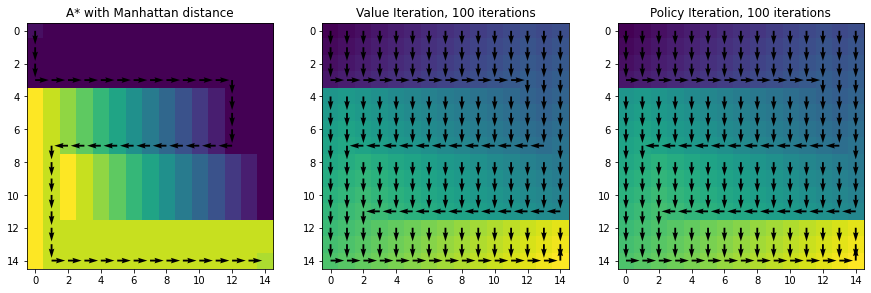

In [ ]:
fig, axs = plt.subplots(1, 3)

# Plot for A*
for node, f_n in enqueued.items():
    grid[node[0]][node[1]] = sum(f_n)
axs[0].imshow(grid)
# Plot the path for A*
for i in range(len(path)-1):
    src = path[i]
    dst = path[i+1]
    axs[0].quiver(src[1], src[0], dst[1]-src[1], src[0]-dst[0])

# Plot for value iteration alpha = 0, 100 iterations
plot_value_grid(val1, pol1, axs[1])
# Plot for policy iteration alpha = 0, k_max = 100, run for 100 iterations
plot_value_grid(val2, pol2, axs[2])
# Set title for each plot
axs[0].title.set_text('A* with Manhattan distance')
axs[1].title.set_text('Value Iteration, 100 iterations')
axs[2].title.set_text('Policy Iteration, 100 iterations')
fig.set_size_inches(15, 5)

### B. Repeat Value and Policy iteration for 10, 20 and 100 iterations with $\alpha \in \{0.2, 0.8\}$

#### I. Value Iteration

/usr/local/lib/python3.7/dist-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.7/dist-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


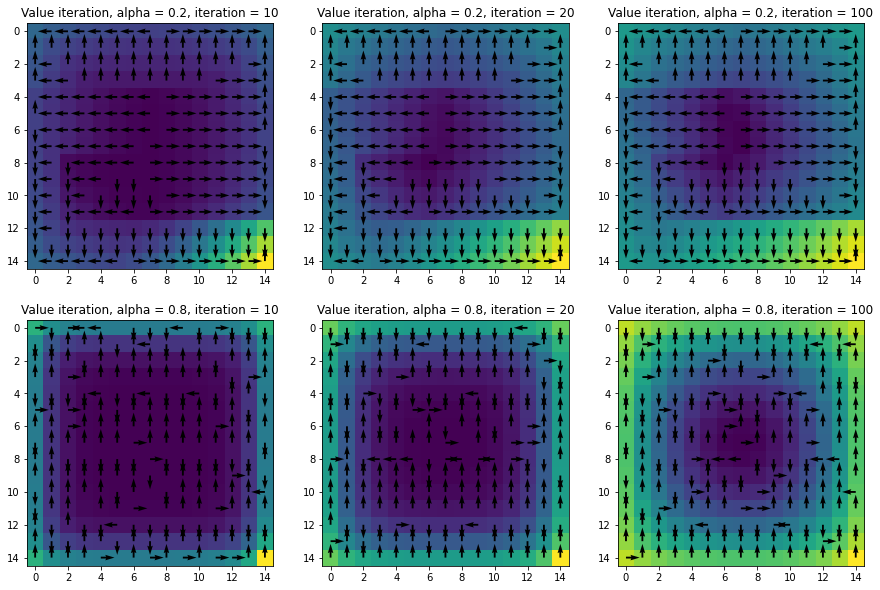

In [ ]:
fig, axs = plt.subplots(2, 3)

for idx1, alpha in enumerate(ALPHA):
    for idx2, i in enumerate([10, 20, 100]):
        val, pol = value_iteration(S, A, P, R, alpha = alpha, ctr = i)
        plot_value_grid(val, pol, axs[idx1][idx2])
        axs[idx1][idx2].title.set_text(
            'Value iteration, alpha = {}, iteration = {}'.format(alpha, i))
fig.set_size_inches(15, 10)

As the noise (denoted by alpha) increases, we see that the policy becomes worse. We can also see that as the number of iterations increase, the policy improves. Compared to the case when alpha was 0, the value iteration no longer converges, and therefore requires more iterations to achieve the optimal policy.

#### II. Policy Iteration

Converged at iteration 9
Converged at iteration 7


/usr/local/lib/python3.7/dist-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.7/dist-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


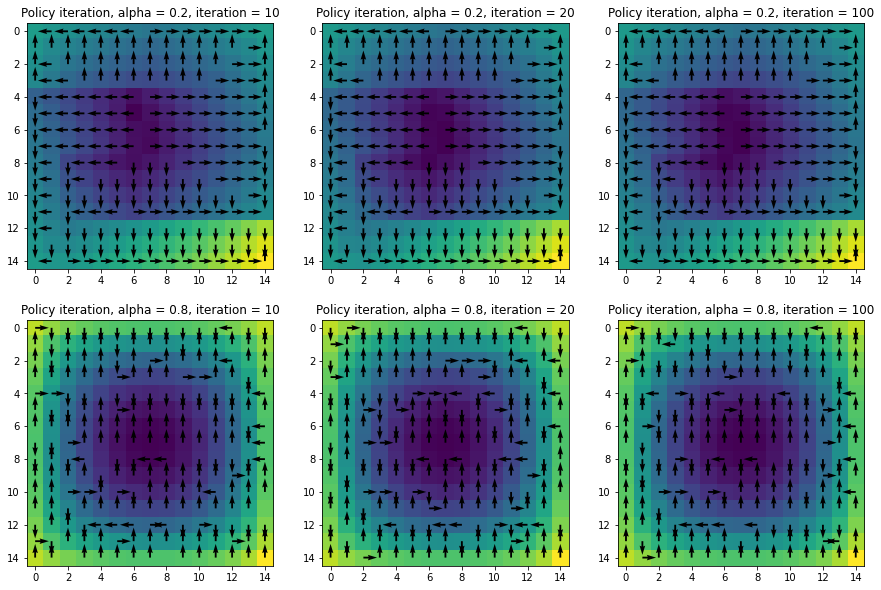

In [ ]:
fig, axs = plt.subplots(2, 3)

for idx1, alpha in enumerate(ALPHA):
    for idx2, i in enumerate([10, 20, 100]):
        val, pol = policy_iteration(S, A, P, R, alpha = alpha,
                                    ctr = i, k_max = 100)
        plot_value_grid(val, pol, axs[idx1][idx2])   
        axs[idx1][idx2].title.set_text(
            'Policy iteration, alpha = {}, iteration = {}'.format(alpha, i))
fig.set_size_inches(15, 10)     

We see similar results for policy iteration as well. As the noise (denoted by alpha) increases, we see that the policy becomes worse. We can also see that as the number of iterations increase, the policy improves. While policy iteration converges in some cases, it takes much longer to run than value iteration because of the iterative policy evaluation step.

An interesting consequence of using values of alpha other than zero was the significant increase in time each iteration took for both value and policy iterations.